# Proyecto Interconnect

##  Objetivo
La compañía de TELECOM 'Interconnect ’ busca poder pronosticar su tasa de cancelación de clientes, con la finalidad de ofrecer códigos promocionales y opciones de planes especiales en caso de conocer que un cliente pudiera dejar la compañía.

##  Recursos
El equipo de marketing de Interconnect proporciona la información que ha recopilado de algunos de sus clientes, y nos proporciona dicha información en 4 archivos.

## A considerar...

Para considerar este trabajo, se cuenta con la siguiente escala:

    Criterios de evaluación:

    - AUC-ROC < 0.75 — 0 SP
    - 0.75 ≤ AUC-ROC < 0.81 — 4 SP
    - 0.81 ≤ AUC-ROC < 0.85 — 4.5 SP
    - 0.85 ≤ AUC-ROC < 0.87 — 5 SP
    - 0.87 ≤ AUC-ROC < 0.88 — 5.5 SP
    - AUC-ROC ≥ 0.88 — 6 SP
    



##  Descripción de los datos
Los datos consisten en archivos obtenidos de diferentes fuentes y se describe a continuación el contenido generico de cada archivo:

    - contract.csv — información del contrato
    - personal.csv — datos personales del cliente
    - internet.csv — información sobre los servicios de Internet
    - phone.csv — información sobre los servicios telefónicos
    
Nota: En cada archivo, la columna customerID (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020

###  EDA

In [1]:
# importación de librerias

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from scipy.stats import chi2_contingency, pointbiserialr

In [2]:
# carga de dataframes

contract = pd.read_csv('/datasets/final_provider/contract.csv', parse_dates=['EndDate'])
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

#### contract

In [3]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
# defino función para valores únicos por columna

def unique_values(dataframe):
    for column in dataframe.columns:
        unique_values = dataframe[column].unique()
        print(f"Valores únicos en la columna '{column}':")
        print(unique_values)
        print()

In [5]:
unique_values(contract)

Valores únicos en la columna 'customerID':
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Valores únicos en la columna 'BeginDate':
['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-0

In [6]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [7]:
contract.isnull().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [8]:
print(f'El número total de filas duplicadas en este archivo es de {contract.duplicated().sum()} filas.')

El número total de filas duplicadas en este archivo es de 0 filas.


In [9]:
contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


#### personal

In [10]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [11]:
unique_values(personal)

Valores únicos en la columna 'customerID':
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Valores únicos en la columna 'gender':
['Female' 'Male']

Valores únicos en la columna 'SeniorCitizen':
[0 1]

Valores únicos en la columna 'Partner':
['Yes' 'No']

Valores únicos en la columna 'Dependents':
['No' 'Yes']



In [12]:
personal.isnull().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [13]:
print(f'El número total de filas duplicadas en este archivo es de {personal.duplicated().sum()} filas.')

El número total de filas duplicadas en este archivo es de 0 filas.


In [14]:
personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


#### internet

In [15]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [16]:
unique_values(internet)

Valores únicos en la columna 'customerID':
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Valores únicos en la columna 'InternetService':
['DSL' 'Fiber optic']

Valores únicos en la columna 'OnlineSecurity':
['No' 'Yes']

Valores únicos en la columna 'OnlineBackup':
['Yes' 'No']

Valores únicos en la columna 'DeviceProtection':
['No' 'Yes']

Valores únicos en la columna 'TechSupport':
['No' 'Yes']

Valores únicos en la columna 'StreamingTV':
['No' 'Yes']

Valores únicos en la columna 'StreamingMovies':
['No' 'Yes']



In [17]:
internet.isnull().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [18]:
print(f'El número total de filas duplicadas en este archivo es de {internet.duplicated().sum()} filas.')

El número total de filas duplicadas en este archivo es de 0 filas.


In [19]:
internet.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


#### phone

In [20]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [21]:
unique_values(phone)

Valores únicos en la columna 'customerID':
['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']

Valores únicos en la columna 'MultipleLines':
['No' 'Yes']



In [22]:
phone.isnull().sum()

customerID       0
MultipleLines    0
dtype: int64

In [23]:
print(f'El número total de filas duplicadas en este archivo es de {phone.duplicated().sum()} filas.')

El número total de filas duplicadas en este archivo es de 0 filas.


In [24]:
phone.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


###  Observaciones
Descripción de los datos presentes en los archivos proporcionados por la compañia:

contract — información del contrato (7043 observaciones):

    - customerID
    - BeginDate (2013…2020)
    - EndDate (no | (fecha YYYY/MM/DD))
    - Type (Month-to-month | One Year | Two Year)
    - PaperlessBilling (No | Yes)
    - PaymentMethod (Bank transfer (automatic) | Credit card (automatic) | Electronic check | Mailed check)
    - MonthlyCharges ( .)
    - 𝑇𝑜𝑡𝑎𝑙𝐶ℎ𝑎𝑟𝑔𝑒𝑠( .$$)

internet — información sobre los servicios de Internet (5517 observaciones):

    - customerID
    - InternetServices (DLS | Fiber optic)
    - OnlineSecurity (Yes | no)
    - OnlineBackup (Yes | no)
    - DeviceProtect (Yes | no)
    - TechSupport (Yes | no)
    - StreamingTV (Yes | no)
    - StreamingMovies (Yes | no)

personal — datos personales del cliente (7043 observaciones):

    - gender (female | male)
    - SeniorCitizen (1 | 0)
    - Partner (Yes | no)
    - Dependents (Yes | no)

phone — información sobre los servicios telefónicos (6361 observaciones)

    - customerID
    - MultipleLines (Yes/No)
Se sabe que el tipo de servicios proporcionados por la compañía son:

Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
Internet. La red se puede configurar a través de una línea telefónica (DSL, línea de abonado digital) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

Seguridad en Internet: software antivirus (ProtecciónDeDispositivo) y un bloqueador de sitios web maliciosos (SeguridadEnLínea).
Una línea de soporte técnico (SoporteTécnico).
Almacenamiento de archivos en la nube y backup de datos (BackupOnline).
Streaming de TV (StreamingTV) y directorio de películas (StreamingPelículas)

Característica objetivo: la columna 'EndDate' es igual a 'No'.

## Preprocesamiento

Salta a la vista que la columna 'TotalCharges' de 'contract', se muestra como un dato tipo "objetct" cuando deberían ser identificado como una columnas con cantidades númericas.

In [25]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

In [26]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [27]:
contract.isnull().sum()

customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
dtype: int64

In [28]:
null_data_nan = contract[contract['TotalCharges'].isna()]

display(null_data_nan)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


Se observa que tenemos 11 datos NaN en la parte de 'TotalCharges' y es probable que sea porque sean clientes que apenas han aperturado su contrato, puesto que probablemente, la base de datos se descargaron en la fecha donde aun no cumplian 1 mes. Se procede a eliminar esos 11 registros.

In [29]:
contract = contract.drop(contract[contract['TotalCharges'].isna()].index)
contract = contract.reset_index(drop=True)

In [30]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 439.6+ KB


Se realiza la unión de los dataframes para trabajar en 1 solo

In [31]:
df = contract.merge(internet, how='left', on='customerID')
df = df.merge(personal, how='left', on='customerID')
df = df.merge(phone, how='left', on='customerID')

df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


Una vez con todos los dataframes juntos, se procede a adaptar los datos para ser ocupados en los modelos futuros.

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   InternetService   5512 non-null   object 
 9   OnlineSecurity    5512 non-null   object 
 10  OnlineBackup      5512 non-null   object 
 11  DeviceProtection  5512 non-null   object 
 12  TechSupport       5512 non-null   object 
 13  StreamingTV       5512 non-null   object 
 14  StreamingMovies   5512 non-null   object 
 15  gender            7032 non-null   object 
 16  SeniorCitizen     7032 non-null   int64  


In [33]:
df.isnull().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        680
dtype: int64

De los datos faltantes:

phone

    - MultipleLines: el cliente no cuenta con servicio de telefonía. Los nulos se procederán a rellenar con "No"
    
internet

     - DataFrame completo: el clienteno cuenta con servicio de internet, solo de telefonia
     
Por lo tanto, en los datos nulos del dataframe, se colocarán "0", como representación de 'no'

In [34]:
for col in ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "MultipleLines"]:
  df[col] = df[col].fillna("No")

In [35]:
df["InternetService"] = df["InternetService"].fillna("No Service")

In [36]:
df.isnull().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
dtype: int64

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  gender            7032 non-null   object 
 16  SeniorCitizen     7032 non-null   int64  


### Creación de nuevas columnas

Se crea una nueva columna que nos indicará si el cliente se ha marchado o no

In [38]:
df['exited'] = (df['EndDate'] != 'No').astype(int)

Se crea una nueva columna que incluya indique cuanto tiempo lleva el cliente con la compañia.

Para ello se sustituye el valor 'No' de la columna end_date por la fecha de extracción de los datos, que fue el 2020-02-01.

In [39]:
df.loc[df['EndDate'] == 'No', 'EndDate'] = '2020-02-01 00:00:00'
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d %H:%M:%S')
extraction_date = pd.to_datetime('2020-02-01 00:00:00')
df['days_since_join'] = (extraction_date - df['BeginDate']).dt.days

In [40]:
df.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,exited,days_since_join
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,Female,0,Yes,No,No,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,DSL,Yes,...,No,No,No,Male,0,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,Male,0,No,No,No,1,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,Yes,No,No,Male,0,No,No,No,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,Female,0,No,No,No,1,153
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,Fiber optic,No,...,No,Yes,Yes,Female,0,No,No,Yes,1,337
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Fiber optic,No,...,No,Yes,No,Male,0,No,Yes,Yes,0,671
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,301.90,DSL,Yes,...,No,No,No,Female,0,No,No,No,0,306
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,Fiber optic,No,...,Yes,Yes,Yes,Female,0,Yes,No,Yes,1,945
9,6388-TABGU,2014-12-01,2020-02-01,One year,No,Bank transfer (automatic),56.15,3487.95,DSL,Yes,...,No,No,No,Male,0,No,Yes,No,0,1888


### Codificación

Se cambian los datos, por lo que se codifica las respuestas binarias "Yes" y "No" a números enteros, asignando el valor 1 a "Yes" y el valor 0 a "No".

In [41]:
for col in df.columns:
    if set(df[col].unique()) == {"No", "Yes"}:
        df[col] = (df[col] == "Yes").astype(int)

In [42]:
df["gender"] = (df["gender"] == "Male").astype("int")

In [43]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,exited,days_since_join
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,DSL,0,...,0,0,0,0,0,1,0,0,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50,DSL,1,...,0,0,0,1,0,0,0,0,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,DSL,1,...,0,0,0,1,0,0,0,0,1,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,DSL,1,...,1,0,0,1,0,0,0,0,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,Fiber optic,0,...,0,0,0,0,0,0,0,0,1,153


Para continuar, se convierten los nombres de las columnas a "snake_case"

In [44]:
def to_snake_case(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [45]:
df.columns = [to_snake_case(col) for col in df.columns]

### Revisión de datos

Se hace una revisión de estadistica descriptiva

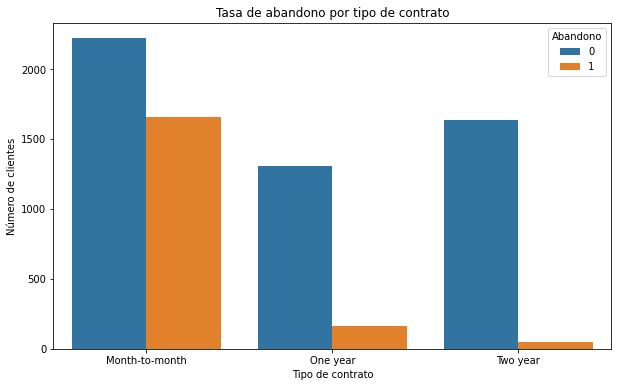

In [46]:
plt.figure(figsize=(10, 6))
sns.countplot(x='type', hue='exited', data=df)
plt.title('Tasa de abandono por tipo de contrato')
plt.xlabel('Tipo de contrato')
plt.ylabel('Número de clientes')
plt.legend(title='Abandono')
plt.show()

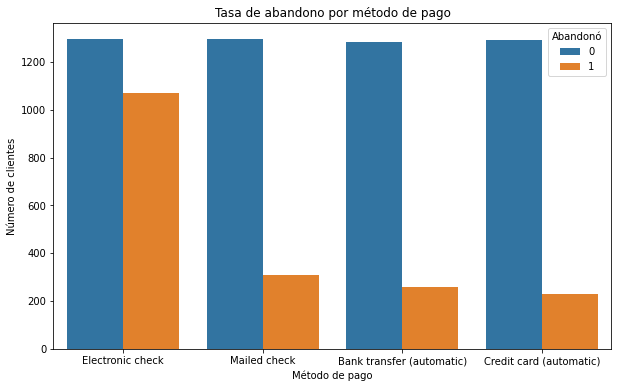

In [47]:
plt.figure(figsize=(10, 6))
sns.countplot(x='payment_method', hue='exited', data=df)
plt.title('Tasa de abandono por método de pago')
plt.xlabel('Método de pago')
plt.ylabel('Número de clientes')
plt.legend(title='Abandonó')
plt.show()

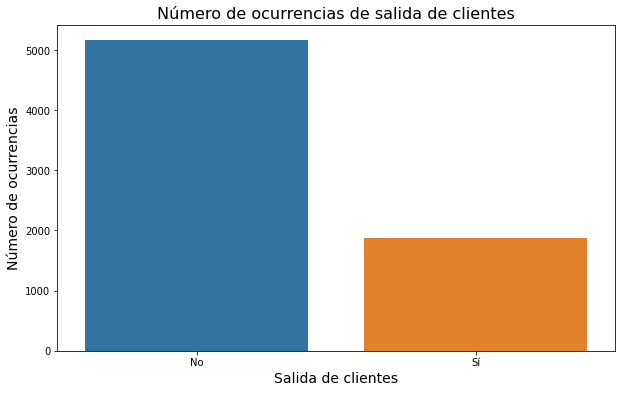

In [48]:
plt.figure(figsize=(10, 6))
sns.countplot(x='exited', data=df)
plt.title('Número de ocurrencias de salida de clientes', fontsize=16)
plt.xlabel('Salida de clientes', fontsize=14)
plt.ylabel('Número de ocurrencias', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])
plt.show()

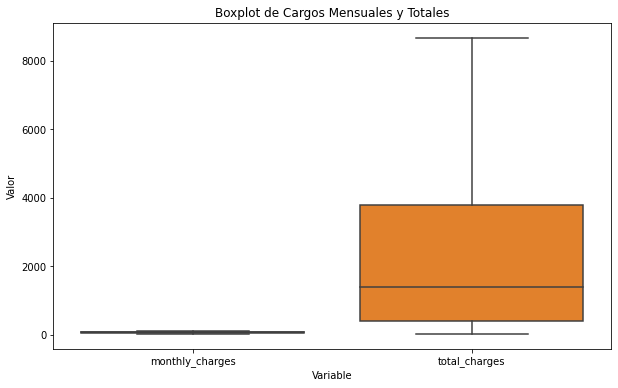

In [49]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['monthly_charges', 'total_charges']])
plt.title('Boxplot de Cargos Mensuales y Totales')
plt.xlabel('Variable')
plt.ylabel('Valor')
plt.show()

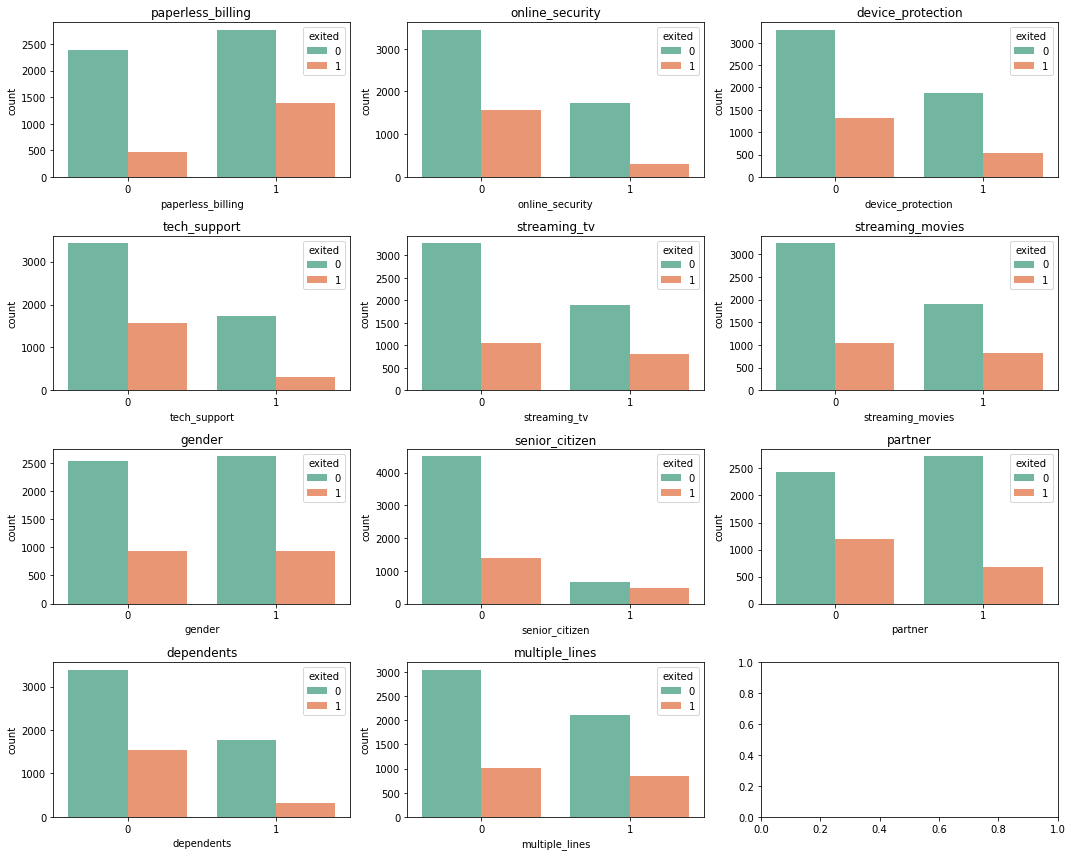

In [50]:
categories = ['paperless_billing', 'online_security', 'device_protection', 'tech_support', 
              'streaming_tv', 'streaming_movies', 'gender', 'senior_citizen', 'partner', 
              'dependents', 'multiple_lines']

target = 'exited'

num_rows = 4
num_cols = 3

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))

for i, cat_col in enumerate(categories):
    row = i // num_cols
    col = i % num_cols
    sns.countplot(data=df, x=cat_col, hue=target, palette='Set2', ax=axs[row, col])
    axs[row, col].set_title(cat_col)

plt.tight_layout()
plt.show()

In [51]:
# Separación de variables por su tipo de variable
categorical_variables = ['type', 'payment_method', 'internet_service']
binary_variables = ['paperless_billing', 'online_security', 'device_protection', 
                    'tech_support', 'streaming_tv', 'streaming_movies', 
                    'gender', 'senior_citizen', 'partner', 'dependents', 
                    'multiple_lines', 'online_backup']

# creación de tabla de contingencia o tabulación cruzada, 
for cat_var in categorical_variables + binary_variables:
    contingency_table = pd.crosstab(df[cat_var], df['exited'])
    # desempaquetado de tuplas
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"Prueba de Chi-cuadrado para {cat_var} vs. exited: P-Valor= {p:.3f}")

Prueba de Chi-cuadrado para type vs. exited: valor p = 0.000
Prueba de Chi-cuadrado para payment_method vs. exited: valor p = 0.000
Prueba de Chi-cuadrado para internet_service vs. exited: valor p = 0.000
Prueba de Chi-cuadrado para paperless_billing vs. exited: valor p = 0.000
Prueba de Chi-cuadrado para online_security vs. exited: valor p = 0.000
Prueba de Chi-cuadrado para device_protection vs. exited: valor p = 0.000
Prueba de Chi-cuadrado para tech_support vs. exited: valor p = 0.000
Prueba de Chi-cuadrado para streaming_tv vs. exited: valor p = 0.000
Prueba de Chi-cuadrado para streaming_movies vs. exited: valor p = 0.000
Prueba de Chi-cuadrado para gender vs. exited: valor p = 0.490
Prueba de Chi-cuadrado para senior_citizen vs. exited: valor p = 0.000
Prueba de Chi-cuadrado para partner vs. exited: valor p = 0.000
Prueba de Chi-cuadrado para dependents vs. exited: valor p = 0.000
Prueba de Chi-cuadrado para multiple_lines vs. exited: valor p = 0.001
Prueba de Chi-cuadrado para 

In [52]:
# Variables numéricas
numeric_variables = ['monthly_charges', 'total_charges', 'days_since_join']


for num_var in numeric_variables:
    # desempaquetado de tuplas
    r, p = pointbiserialr(df['exited'], df[num_var])
    print(f"Correlación punto-biserial para {num_var} vs. exited: r = {r:.3f}, P-Valor = {p:.3f}")

Correlación punto-biserial para monthly_charges vs. exited: r = 0.193, valor p = 0.000
Correlación punto-biserial para total_charges vs. exited: r = -0.199, valor p = 0.000
Correlación punto-biserial para days_since_join vs. exited: r = -0.314, valor p = 0.000


Revisando los gráficos, podemos comentar lo siguiente:

    - Es mayor el número de clientes que se marchan de la compañia cuando tienen un tipo de contrato mensual
    - Hay una permanencia mucho más pronunciada para clientes que tienen contratos por 2 años
    - El  número de clientes que se marchan es mayor cuando los clientes pagan por medio electronico
    - La columna objetivo esta desvalanceada, puesto que hay más datos sobre clientes que se quedan, que de clientes que se van
    - No existen outliers en ambito de los cargos tanto mensuales como totales

Se realiza una 'tabla de contingencia' y se aplica el 'test chi2' para analizar la asociación entre las variables cualitativas y la variable objetivo 'exited'. Con base a los resultados obtenidos en P-valor:
    
    - Todas las variables muestran una asociación significativa con 'exited', excepto la variable 'gender', la cual no muestra una asociación significativa debido a un P-valor mayor a 0.05

Al realizar una prueba de correlación punto-biserial para las variables numéricas en relación con la variable objetivo 'exited', se encuentra una correlación significativa entre las variables 'monthly_charges', 'total_charges' y 'days_since_join' con 'exited'. Se detalla a continuación:

    - 'monthly_charges' muestra una correlación positiva, lo que sugiere que a medida que los cargos mensuales aumentan, la probabilidad de abandono también tiende a aumentar
    - 'total_charges' y 'days_since_join' muestran correlaciones negativas, indicando que a medida que el total de cargos acumulados o el tiempo desde la unión a la empresa aumentan, la probabilidad de abandono tiende a disminuir
    
Al obtener un P-valor con valor de '0', se puede indicar que es poco probable que las correlaciones obtenidas en la prueba de correlación punto-biserialsean resultado del azar, puesto que los resultados son confiables. 

    
Para terminar de tener listo los datos, se eliminarán las siguientes variables:

    - customer_id: no agrega valor al modelo
    - begin_date y end_date: con base a estas columnas se creó la columna 'days_since_join', por lo que se puede eliminar
    - Se puede eliminar 'gender'puesto que se demostró que no tenia una asociación significativa con la variable objetivo 

In [53]:
df = df.drop(['customer_id', 'begin_date', 'end_date', 'gender'], axis=1)

In [54]:
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,senior_citizen,partner,dependents,multiple_lines,exited,days_since_join
0,Month-to-month,1,Electronic check,29.85,29.85,DSL,0,1,0,0,0,0,0,1,0,0,0,31
1,One year,0,Mailed check,56.95,1889.50,DSL,1,0,1,0,0,0,0,0,0,0,0,1036
2,Month-to-month,1,Mailed check,53.85,108.15,DSL,1,1,0,0,0,0,0,0,0,0,1,123
3,One year,0,Bank transfer (automatic),42.30,1840.75,DSL,1,0,1,1,0,0,0,0,0,0,0,1371
4,Month-to-month,1,Electronic check,70.70,151.65,Fiber optic,0,0,0,0,0,0,0,0,0,0,1,153


Se realiza una estandarización de las características numéricas 

In [55]:
numeric_cols = ["total_charges", "monthly_charges", "days_since_join"]
scaler = StandardScaler()
scaler.fit(df[numeric_cols])

df[numeric_cols] = scaler.transform(df[numeric_cols])

## Entrenamiento del modelo

Una vez con los datos listos, se separan los datos:    

In [56]:
target = df['exited']
features = df.drop('exited', axis=1)

Codificación de rasgos categóricos

Al revisar las variables, se decide utilizar OHE. 

In [57]:
features = pd.get_dummies(features, drop_first=True)

In [58]:
features

,paperless_billing,monthly_charges,total_charges,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,senior_citizen,...,dependents,multiple_lines,days_since_join,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,internet_service_No Service
0,1,-1.161694,-0.994194,0,1,0,0,0,0,0,...,0,0,-1.327411,0,0,0,1,0,0,0
1,0,-0.260878,-0.173740,1,0,1,0,0,0,0,...,0,0,0.037999,1,0,0,0,1,0,0
2,1,-0.363923,-0.959649,1,1,0,0,0,0,0,...,0,0,-1.202419,0,0,0,0,1,0,0
3,0,-0.747850,-0.195248,1,0,1,1,0,0,0,...,0,0,0.493135,1,0,0,0,0,0,0
4,1,0.196178,-0.940457,0,0,0,0,0,0,0,...,0,0,-1.161660,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,1,0.664868,-0.129180,1,0,1,1,1,1,0,...,1,1,-0.377738,1,0,0,0,1,0,0
7028,1,1.276493,2.241056,0,1,1,0,1,1,0,...,1,1,1.607201,1,0,1,0,0,1,0
7029,1,-1.170004,-0.854514,1,0,0,0,0,0,0,...,1,0,-0.911675,0,0,0,1,0,0,0
7030,1,0.319168,-0.872095,0,0,0,0,0,0,1,...,0,1,-1.077426,0,0,0,0,1,1,0


Separación de datos

### Separación de los datos

Se procede la separación de los datos

    - 60% dataset de entrenamiento
    - 20% dataset de validación
    - 20% Dataset de prueba

In [59]:
train_features, temp_features, train_target, temp_target = train_test_split(
    features, target, test_size=0.40, random_state=12345)

valid_features, test_features, valid_target, test_target = train_test_split(
    temp_features, temp_target, test_size=0.50, random_state=12345)

In [60]:
print('Train set shape:', train_features.shape)
print('Valid set shape:', valid_features.shape)
print('Test set shape:', test_features.shape)

Train set shape: (4219, 21)
Valid set shape: (1406, 21)
Test set shape: (1407, 21)


### Procedimiento de evaluación

Creación de una función que será de ayuda para evaluar la efectividad de los modelos

In [61]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, ax = plt.subplots(figsize=(10, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        eval_stats[type] = {}
        
        if type == 'train':
            color = 'blue'
            data = train_features
            true_target = train_target
        else:
            color = 'green'
            data = test_features
            true_target = test_target
    
        pred_proba = cross_val_predict(model, data, true_target, cv=5, method='predict_proba')[:, 1]
        
        # pred_proba = model.predict_proba(features)[:, 1]
        
        fpr, tpr, roc_thresholds = metrics.roc_curve(true_target, pred_proba)
        roc_auc = metrics.roc_auc_score(true_target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc


        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        pred_target = cross_val_predict(model, data, true_target, cv=5)
        #pred_target = model.predict(features)
        
        eval_stats[type]['Accuracy'] = metrics.accuracy_score(true_target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return df_eval_stats

## Modelos

### Modelo base

          train  test
Accuracy   0.27  0.27
ROC AUC    0.50  0.50


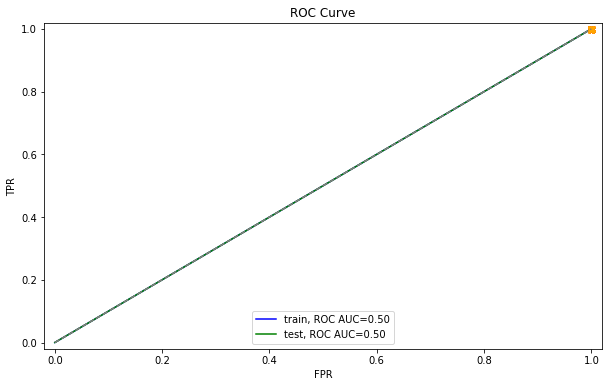

In [62]:
base_model = DummyClassifier(strategy='constant', constant=1, random_state=12345)
base_model.fit(train_features, train_target)

result = evaluate_model(base_model, train_features, train_target, test_features, test_target)

Este modelo base simplemente está prediciendo la clase mayoritaria en todos los casos. Esto sugiere que cualquier modelo más complejo que se desarrolle, debe superar este rendimiento básico para considerarse útil.

### Regresión logística con equilibrio de clase

          train  test
Accuracy   0.75  0.74
ROC AUC    0.84  0.83


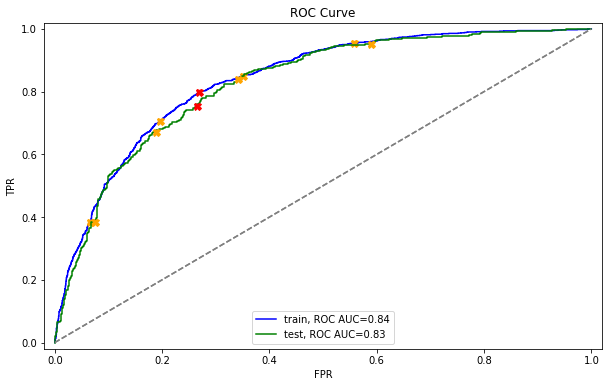

In [63]:
lr_model = LogisticRegression(random_state=12345, class_weight='balanced')
lr_model.fit(train_features, train_target)     

result = evaluate_model(lr_model, train_features, train_target, test_features, test_target)

### Bosque aleatorio con equilibrio de clase

          train  test
Accuracy   0.81  0.79
ROC AUC    0.87  0.84


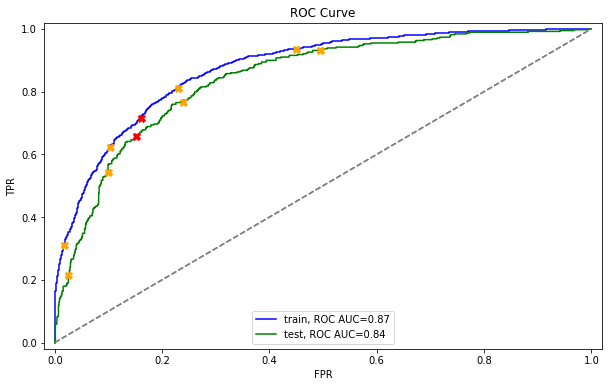

In [64]:
rfc = RandomForestClassifier(class_weight='balanced')

params = {
    "n_estimators": [500, 700],
    "max_depth": [6, 7, 8, 9, 10]
}

gsSVR = GridSearchCV(estimator=rfc, param_grid=params, n_jobs=-1, verbose=0, scoring='roc_auc')

gsSVR.fit(train_features, train_target)

result = evaluate_model(gsSVR, train_features, train_target, test_features, test_target)

### LGBM con equilibrio de clase

          train  test
Accuracy   0.86  0.84
ROC AUC    0.92  0.89


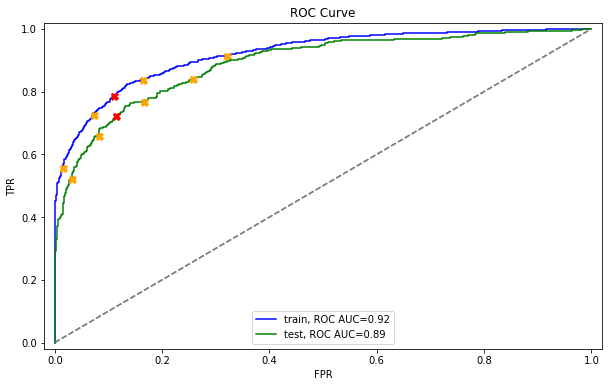

In [65]:
lgbm = LGBMClassifier(random_state=12345, class_weight='balanced')
lgbm.fit(train_features, train_target)

result = evaluate_model(lgbm, train_features, train_target, test_features, test_target)

### CatBoost

          train  test
Accuracy   0.88  0.83
ROC AUC    0.92  0.88


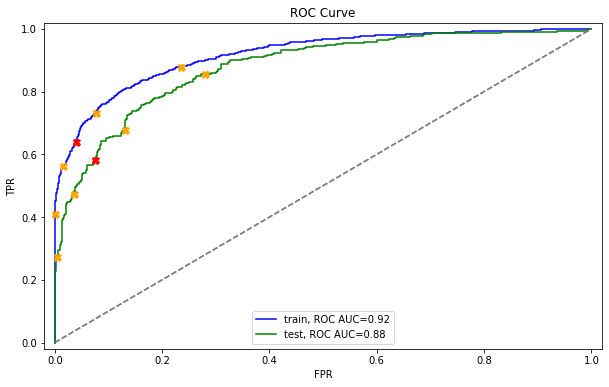

In [66]:
CB = CatBoostClassifier(random_state=12345, verbose=0)
CB.fit(train_features, train_target)

result = evaluate_model(CB, train_features, train_target, test_features, test_target)

Los resultados obtenidos son:

| Modelo                            | ROC AUC (train) | ROC AUC (test) | Accuracy (train) | Accuracy (test) |
|-----------------------------------|-----------------|----------------|------------------|-----------------|
| Regresión logística               | 0.84            | 0.83           | 0.75             | 0.74            |
| Bosque aleatorio                  | 0.87            | 0.84           | 0.81             | 0.79            |
| LGBM                              | 0.92            | 0.89           | 0.86             | 0.84            |
| CatBoost                          | 0.92            | 0.88           | 0.88             | 0.83            |


Acorde a lo visualizado, se reflexiona lo siguiente:

    - Regresión Logística y Bosque Aleatorio: logran un buen rendimiento en cuanto a ROC AUC en ambos conjuntos de datos de entrenamiento y prueba, su precisión es moderada

    - LGBM con Balanceo de Clase:  muestra un mejor rendimiento que los modelos anteriores, con un buen ROC AUC tanto en el aspecto de prueba como en de test

    - CatBoost: CatBoost también muestra un rendimiento sólido en ambos conjuntos de datos, con un alto ROC AUC y precisión
    
Se tienen 2 buenos modelos, se elige CatBoost.

## Prueba del modelo elegido

          train  test
Accuracy   0.88  0.88
ROC AUC    0.92  0.90


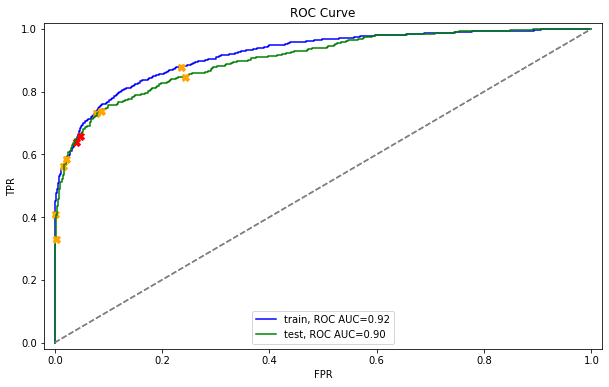

In [67]:
result = evaluate_model(CB, train_features, train_target, valid_features, valid_target)

Recordando los criterios de evaluación, con un resultado en la prueba de validación, se obtuvo un valor en ROC AUC de un .90, superándo el criterio máximo solicitado. 

Criterios de evaluación:

- AUC-ROC < 0.75 — 0 SP
- 0.75 ≤ AUC-ROC < 0.81 — 4 SP
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 SP
- 0.85 ≤ AUC-ROC < 0.87 — 5 SP
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 SP
- AUC-ROC ≥ 0.88 — 6 SP

## Conclusión

Con el objetivo de desarrollar un modelo de clasificación binario que predijera si un cliente abandonará pronto la empresa, se comienza a trabajar sobre este objetivo, tomando como base los datos personales de la clientes, información proporcionada por el departamento de Marketing de la compañia en cuestión. 

Como métrica de evaluación, se ha considerado el AUC-ROC, el cual debe ser superior a 0.88 para cumplir con los objetivos establecidos.

Durante el desarrollo de este proyecto, se han seguido los siguientes pasos:

Inicio del proyecto:

    - Se importaron las bibliotecas necesarias para cumplir con los objetivos del proyecto y se cargaron los conjuntos de datos de contratos, clientes y servicios de internet y teléfono desde archivos CSV

    - Análisis exploratorio de datos (EDA): Se llevó a cabo un análisis exploratorio exhaustivo utilizando herramientas de Python y varias bibliotecas populares como pandas, numpy, seaborn y matplotlib

    - Preprocesamiento de datos: Se trató los datos faltantes en las columnas relacionadas con los servicios de internet y teléfono, y se crearon columnas adicionales con base a otras columnas

    - Estadística descriptiva: Se realizó una evaluación de los datos utilizando diferentes gráficos y técnicas de estadísticas descriptivas
    
    - Se aplica una 'tabla de contingencia' y se aplica el 'test chi2' para analizar la asociación entre las variables cualitativas y la variable objetivo 'exited'. Y para las variables numéricas se aplica una prueba de correlación punto-biserial para encontrar la correlación de estas variables con nuestra variable objetivo. Después de esto, se procede a eliminar las columnas que no aportan valor al modelo

    - División de los datos: Los datos se dividieron en conjuntos de entrenamiento, validación y prueba en proporciones de 60%, 20% y 20%, respectivamente

    - Función de evaluación: Se creó una función para evaluar el rendimiento de los modelos y mostrar los resultados obtenidos

    - Ejecución de modelos: Se entrenaron diferentes modelos, desde un modelo base hasta modelos más avanzados como Regresión Logística, Bosque Aleatorio, LGBM y CatBoost

    - Selección del modelo: Se seleccionó el modelo CatBoost como el modelo final para ejecutar la prueba, ya que obtuvo los mejores resultados. En este caso, el proyecto logró una puntuación de 0.90 en la métrica de ROC AUC y un 0.88 de precisión (Accuracy), cumpliendo con las métricas propuestas